In [1]:
from functools import partial

import numpy as np
import pandas as pd
import scipy.stats as sts
import numpy.random as npr

import arviz as av
import seaborn as sns
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

import mcx
import mcx.distributions as dist
from mcx import sample_joint, sampler, HMC

# sns.set_style("darkgrid")
# Trigger the warning about missing GPUs
jnp.ones(1);

# Code 4.1

In [2]:
def get_distances(num_people: int = 1000, num_steps: int = 16):
    steps = npr.uniform(-1.0, 1.0, size=(num_people, num_steps))
    positions = steps.sum(1)
    
    return steps, positions

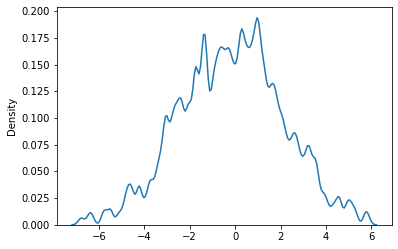

In [3]:
_, pos = get_distances()
sns.kdeplot(pos, bw_method=0.05);

# Figure 4.2 Top

In [4]:
steps, _ = get_distances(num_people=100)
n = len(steps)

positions = np.cumsum(steps, axis=1)
positions = np.c_[np.zeros((n, )), positions]

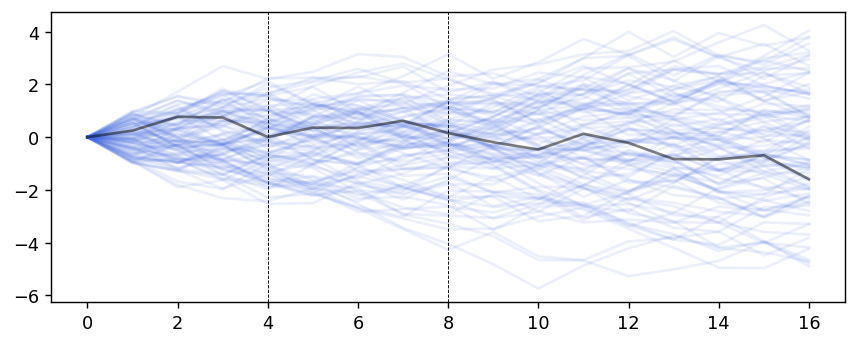

In [5]:
n, m = positions.shape
fig, ax = plt.subplots(figsize=(8, 3), dpi=128)
x = np.arange(m)

for i in range(n - 1):
    ax.plot(x, positions[i, :], alpha=0.1, color="royalblue")

ax.plot(x, positions[-1, :], alpha=0.5, color="black")    
ax.axvline(4, linestyle="--", lw=0.5, color="black");
ax.axvline(8, linestyle="--", lw=0.5, color="black");

# Figure 4.2 bottom

In [6]:
def normal_pdf(μ, σ):
    
    π = np.pi
    x = np.linspace(μ - 3 * σ, μ + 3 * σ, 10_000)
    z = σ * np.sqrt(2 * π)
    y = (1 / z) * np.exp(-0.5 * ((x - μ) / σ) ** 2)

    return x, y

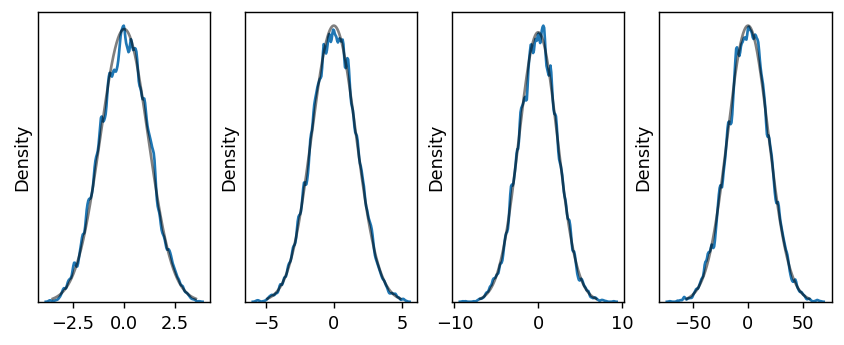

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(8, 3), dpi=128)
ns = [4, 8, 16, 1024]

for ax, n in zip(axes, ns):
    
    num_people = 10000
    _, pos = get_distances(num_people, n)

    # Plot the sampled distances
    ax = sns.kdeplot(pos, bw_method=0.05, ax=ax)
    
    # Plot the gaussian PDF 
    μ, σ = np.mean(pos), np.std(pos)
    x, y = normal_pdf(μ, σ)
    
    sns.lineplot(x=x, y=y, ax=ax, color="black", alpha=0.5)
    ax.set_yticks([])

# Code 4.2

In [8]:
np.prod(1 + npr.uniform(0.0, 0.1, size=12))

1.9529554270436285

# Code 4.3

<AxesSubplot:ylabel='Density'>

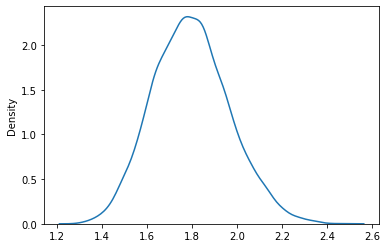

In [9]:
growth = np.prod(1 + npr.uniform(0.0, 0.1, size=(10_000, 12)), axis=1)
sns.kdeplot(growth)

In [10]:
def overlay_normal(data):
    
    mu, sigma = np.mean(data), np.std(data)
    
    x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, len(data))
    pdf = sts.norm(mu, sigma).pdf(x)

    fig, ax = plt.subplots(1, 1, figsize=(4, 2), dpi=128)
    sns.lineplot(x=x, y=pdf, ax=ax, alpha=0.5)
    sns.kdeplot(data, ax=ax, alpha=0.5)

    ax.legend(["Normal", "Prod"])

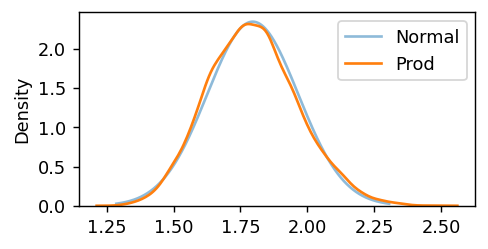

In [11]:
overlay_normal(growth)

# Code 4.4

In [12]:
big = np.prod(1 + npr.uniform(0.0, 0.5, size=(10_000, 12)), axis=1)
smol = np.prod(1 + npr.uniform(0.0, 0.1, size=(10_000, 12)), axis=1)

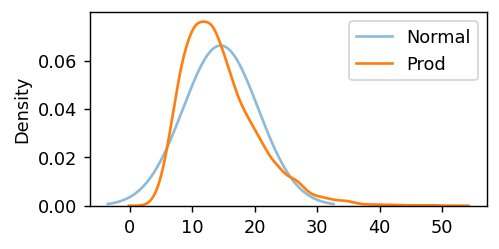

In [13]:
overlay_normal(big)

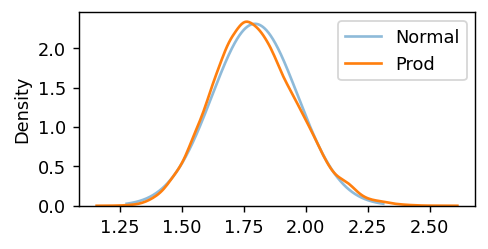

In [14]:
overlay_normal(smol)

# Code 4.5

In [15]:
logbig = np.log(big)

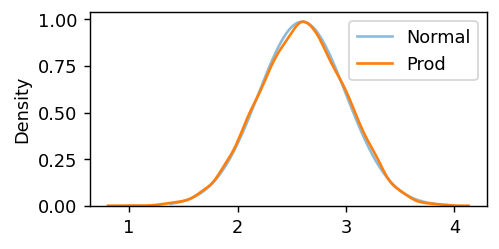

In [16]:
overlay_normal(logbig)

# Code 4.6

In [17]:
w, n = 6, 9

p_grid = np.linspace(0.0, 1.0, 10_00)
posterior = sts.binom(n=n, p=p_grid).pmf(w) * sts.uniform(0, 1).pdf(p_grid)
posterior /= posterior.sum()

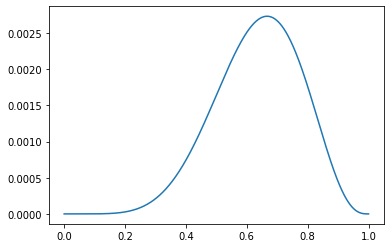

In [18]:
sns.lineplot(x=p_grid, y=posterior);

# Code 4.7

In [19]:
d = pd.read_csv("data/Howell1.csv", sep=";")

# Code 4.8

In [20]:
print(str(d))

      height     weight   age  male
0    151.765  47.825606  63.0     1
1    139.700  36.485807  63.0     0
2    136.525  31.864838  65.0     0
3    156.845  53.041915  41.0     1
4    145.415  41.276872  51.0     0
..       ...        ...   ...   ...
539  145.415  31.127751  17.0     1
540  162.560  52.163080  31.0     1
541  156.210  54.062496  21.0     0
542   71.120   8.051258   0.0     1
543  158.750  52.531624  68.0     1

[544 rows x 4 columns]


# Code 4.9

In [21]:
d.describe()

,height,weight,age,male
count,544.000000,544.000000,544.000000,544.000000
mean,138.263596,35.610618,29.344393,0.472426
std,27.602448,14.719178,20.746888,0.499699
min,53.975000,4.252425,0.000000,0.000000
25%,125.095000,22.007717,12.000000,0.000000
50%,148.590000,40.057844,27.000000,0.000000
75%,157.480000,47.209005,43.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


# Code 4.10

In [22]:
d["height"]

0      151.765
1      139.700
2      136.525
3      156.845
4      145.415
        ...   
539    145.415
540    162.560
541    156.210
542     71.120
543    158.750
Name: height, Length: 544, dtype: float64

# Code 4.11

In [23]:
%timeit d[d.age > 18]

289 µs ± 2.35 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [24]:
%timeit d[d["age"] > 18]

290 µs ± 9.04 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [25]:
%timeit d[d.loc[:, "age"] > 18]

315 µs ± 7.67 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [26]:
%timeit d.query("age > 18")

880 µs ± 11 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Code 4.12

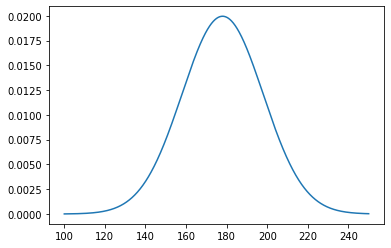

In [27]:
x = np.linspace(100, 250, 1000)
y = sts.norm(178, 20).pdf(x)

sns.lineplot(x=x, y=y);

# Code 4.13

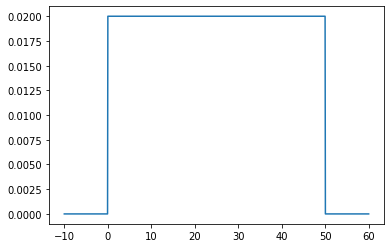

In [28]:
x = np.linspace(-10, 60, 1000)
y = sts.uniform(0, 50).pdf(x)

sns.lineplot(x=x, y=y);

# Code 4.14

In [29]:
N = 10_000

sample_μ = sts.norm(178, 20).rvs(N)
sample_σ = sts.uniform(0, 50).rvs(N)
prior_h  = sts.norm(sample_μ, sample_σ).rvs(N)

<AxesSubplot:ylabel='Density'>

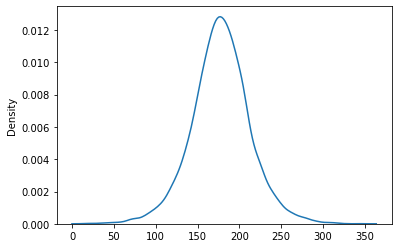

In [30]:
sns.kdeplot(prior_h)

# Figure 4.3 (mcx model)

In [31]:
class _Normal(dist.Normal):
    """ TODO: remove once mcx is patched 
    """

    def __init__(self, mu, sigma, idx: int = 0):
        super().__init__(mu, sigma)
        self.idx = idx
        
    def sample(self, rng_key, sample_shape=()):
        for _ in range(self.idx):
            _, rng_key = jax.random.split(rng_key)

        return super().sample(rng_key, sample_shape=sample_shape)

In [32]:
@mcx.model
def model(mean: float = 178, stdev: float = 20):
    μ <~ _Normal(mean, stdev, 0)
    σ <~ dist.Uniform(0, 50)
    h <~ _Normal(μ, σ, 1)
    
    return h

In [33]:
rng_key = jax.random.PRNGKey(0)

prior_pred_1 = sample_joint(
    rng_key, model, model_args=(178, 20), num_samples=10_000
)["h"]

prior_pred_2 = sample_joint(
    rng_key, model, model_args=(178, 100), num_samples=10_000
)["h"]

In [34]:
def plot_normal(mean, stdev, ax):
    x = np.linspace(mean - 4 * stdev, mean + 4 * stdev, 10_00)
    y = sts.norm(mean, stdev).pdf(x)
    
    ax = sns.lineplot(x=x, y=y, ax=ax)
    ax.set_title(f"Normal({mean}, {stdev})")
    ax.set_xticks([mean - 3 * stdev, mean, mean + 3 * stdev])
    
    return ax
    

def plot_uniform(low, high, ax):
    x = np.linspace(low - 10, high + 10, 10_00)
    y = sts.uniform(low, high - low).pdf(x)
    
    ax = sns.lineplot(x=x, y=y, ax=ax)
    ax.set_title(f"Uniform({low}, {high})")
    ax.set_xticks([low, high])
    
    return ax


def plot_prior_predictive(arr, title, ax):
    samples = np.array(arr)

    mean  = samples.mean()
    stdev = samples.std()
    
    ax = sns.kdeplot(samples, ax=ax, bw_method=0.05)
    ax.set_title(title)
    ax.set_xticks([mean - 3 * stdev, mean, mean + 3 * stdev])
    ax.set_xlim(mean - 5 * stdev, mean + 5 * stdev)
    
    return ax

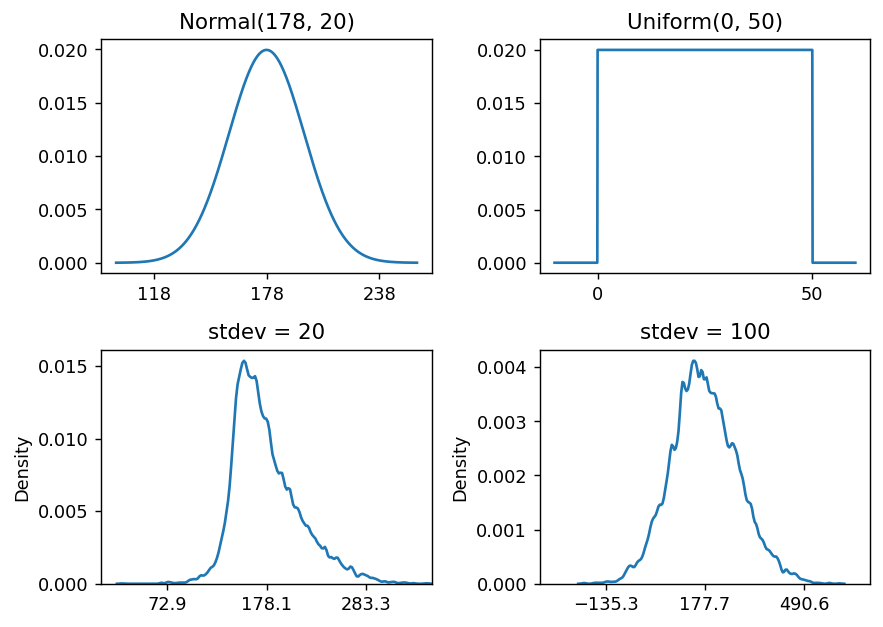

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(7, 5), dpi=128)
axes = axes.reshape(-1)

plot_normal(178, 20, axes[0])
plot_uniform(0, 50,  axes[1])
plot_prior_predictive(prior_pred_1, "stdev = 20",  axes[2])
plot_prior_predictive(prior_pred_2, "stdev = 100", axes[3])

plt.tight_layout()

# Code 4.15

In [36]:
# Skip, we already plotted this above

# Code 4.16 -- reference posterior

In [37]:
d = pd.read_csv("data/Howell1.csv", sep=";")
d2 = d.query("age > 18")

In [38]:
@mcx.model
def model(mean: float = 178, stdev: float = 20):
    μ <~ _Normal(mean, stdev, 0)
    σ <~ dist.Uniform(0, 50)
    h <~ _Normal(μ, σ, 1)
    
    return h

In [39]:
posterior = mcx.sampler(
    rng_key,
    model,
    (178, 20),
    {"h": d2["height"].values},
    HMC(100),
).run()

sampler: build the loglikelihood
sampler: find the initial states
sampler: build and compile the inference kernel


Warming up 4 chains for 1000 steps: 100%|██████████| 1000/1000 [00:01<00:00, 632.63samples/s]


# Code 4.16, 4.17, 4.18, 4.19, 4.20

In [40]:
ref_μ = np.array(posterior["μ"].reshape(-1))
ref_σ = np.array(posterior["σ"].reshape(-1))

In [41]:
H = d2["height"].values[:, None, None]

μs = np.linspace(150, 160, num=100)
σs = np.linspace(7, 9, num=100)

grid_μ, grid_σ = np.meshgrid(μs, σs)
likelihood = sts.norm(grid_μ, grid_σ).pdf(H)

loglik = np.log(likelihood)
loglik = np.sum(loglik, 0)

logprior = (
    np.log(sts.norm(178, 20).pdf(μs)) 
    + np.log(sts.uniform(0, 50).pdf(σs))
)

logprod = loglik + logprior

logprod   -= logprod.max()
posterior  = np.exp(logprod)
posterior /= posterior.sum()

In [42]:
p = posterior.reshape(-1)
n = len(p)

inds = np.random.choice(np.arange(n), 1000, p=p)
samples_μ = grid_μ.reshape(-1)[inds]
samples_σ = grid_σ.reshape(-1)[inds]

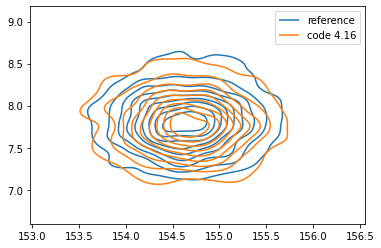

In [48]:
ax = sns.kdeplot(x=ref_μ, y=ref_σ, fill=False)
ax = sns.kdeplot(x=samples_μ, y=samples_σ, fill=False, ax=ax)
ax.legend(["reference", "code 4.16"]);

# Code 4.21

<AxesSubplot:ylabel='Density'>

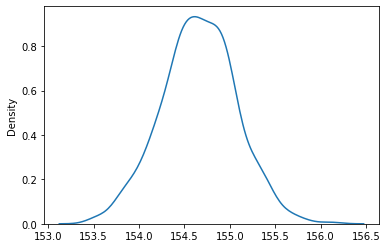

In [49]:
sns.kdeplot(samples_μ)

<AxesSubplot:ylabel='Density'>

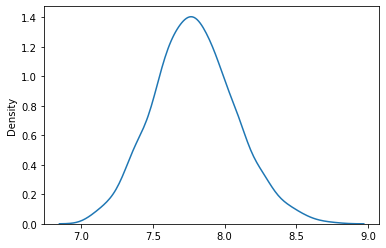

In [50]:
sns.kdeplot(samples_σ)

# Code 4.22

In [52]:
pd.Series(samples_μ).quantile([0.025, 0.975])

0.025    153.838384
0.975    155.454545
dtype: float64

In [53]:
pd.Series(samples_σ).quantile([0.025, 0.975])

0.025    7.262121
0.975    8.373737
dtype: float64

# Code 4.23, 4.24

We use MCMC to avoid lots of copied boilerplate code.

The point here is to show the skewed posterior for $\sigma$

In [63]:
h = np.random.choice(d2["height"], replace=False, size=20)

posterior = mcx.sampler(
    rng_key,
    model,
    (178, 20),
    {"h": h},
    HMC(100),
).run()

ref_μ = np.array(posterior["μ"].reshape(-1))
ref_σ = np.array(posterior["σ"].reshape(-1))

sampler: build the loglikelihood
sampler: find the initial states
sampler: build and compile the inference kernel


Warming up 4 chains for 1000 steps: 100%|██████████| 1000/1000 [00:01<00:00, 822.52samples/s]


<AxesSubplot:>

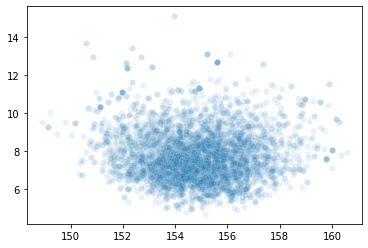

In [64]:
sns.scatterplot(x=ref_μ, y=ref_σ, alpha=0.1)

# Code 4.25

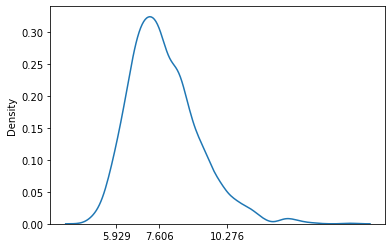

In [69]:
ax = sns.kdeplot(ref_σ)
ax.set_xticks(pd.Series(ref_σ).quantile([0.05, 0.5, 0.95]));

# Code 4.26

In [213]:
from jax import hessian
from scipy.optimize import minimize
from scipy.stats import multivariate_normal

In [214]:
d = pd.read_csv("data/Howell1.csv", sep=";")
d2 = d.query("age >= 18")
h = d2["height"].values

# Code 4.27

In [215]:
@mcx.model
def model(mean: float = 178, stdev: float = 20):
    μ <~ _Normal(mean, stdev, 0)
    σ <~ dist.Uniform(0, 50)
    h <~ _Normal(μ, σ, 1)
    
    return h

In [216]:
def quap(
    model, 
    data: np.ndarray, 
    theta_0: tuple = (), 
    model_kwd: dict = None
):
    
    model_kwd = model_kwd or {}
    
    @jax.jit
    def jax_loss_fn(θ):
        return -model.logpdf(*θ, data, **model_kwd)

    jax_grad_fn = jax.jit(jax.grad(jax_loss_fn))
    jax_hess_fn = jax.jit(jax.hessian(jax_loss_fn))
    
    def py_loss_fn(θ):
        return float(jax_loss_fn(θ))
    
    def py_grad_fn(θ):
        return np.array(jax_grad_fn(θ)).astype(np.float64)
    
    result = minimize(
        fun=py_loss_fn,
        jac=py_grad_fn,
        x0=np.array(theta_0),
        method="L-BFGS-B"
    )
    
    if result.success is False:
        raise RuntimeError("Optimization failed")
    
    θ = result.x
    H = jax_hess_fn(θ)
    precision = jnp.linalg.inv(H)
    
    return θ, precision

# Code 4.28, 4.30

In [217]:
θ, precision = quap(model, h, (h.mean(), h.std()))

# Code 4.29

In [219]:
sd = np.sqrt(np.diag(precision))
res = pd.DataFrame(data={"mean": θ, "sd": sd}, index=["μ", "σ"]).round(2)
res

,mean,sd
μ,154.61,0.41
σ,7.73,0.29


# Comparison of quap and MCMC results

In [220]:
posterior = mcx.sampler(
    rng_key,
    model,
    (178, 20),
    {"h": h},
    HMC(100),
).run()

sampler: build the loglikelihood
sampler: find the initial states
sampler: build and compile the inference kernel


Warming up 4 chains for 1000 steps: 100%|██████████| 1000/1000 [00:01<00:00, 725.75samples/s]


In [221]:
ref_μ = np.array(posterior["μ"].reshape(-1))
ref_σ = np.array(posterior["σ"].reshape(-1))

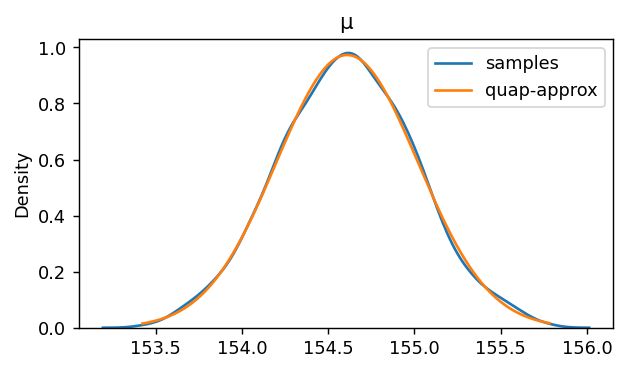

In [226]:
_, ax = plt.subplots(figsize=(5, 3), dpi=128)

n = 10_000
x = np.linspace(ref_μ.min(), ref_μ.max(), n)

ax = sns.kdeplot(ref_μ, ax=ax)
ax = sns.lineplot(
    x=np.linspace(ref_μ.min(), ref_μ.max(), n), 
    y=sts.norm(res.loc["μ", "mean"], res.loc["μ", "sd"]).pdf(x)
)

ax.legend(["samples", "quap-approx"])
ax.set_title("μ")
plt.tight_layout()

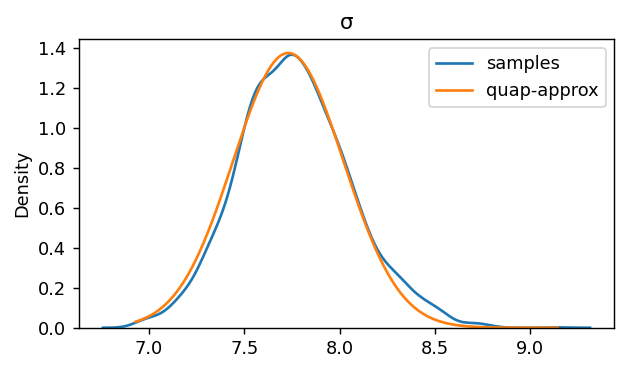

In [227]:
_, ax = plt.subplots(figsize=(5, 3), dpi=128)

n = 10_000
x = np.linspace(ref_σ.min(), ref_σ.max(), n)

ax = sns.kdeplot(ref_σ, ax=ax)
ax = sns.lineplot(
    x=np.linspace(ref_σ.min(), ref_σ.max(), n), 
    y=sts.norm(res.loc["σ", "mean"], res.loc["σ", "sd"]).pdf(x)
)

ax.legend(["samples", "quap-approx"])
ax.set_title("σ")
plt.tight_layout()

# Code 4.31

In [297]:
θ, precision = quap(
    model=model, 
    data=h, 
    theta_0=(h.mean(), h.std()),
    model_kwd={"stdev": 0.1}
)

In [298]:
sd = np.sqrt(np.diag(precision))
pd.DataFrame(data={"mean": θ, "sd": sd}, index=["μ", "σ"]).round(2)

,mean,sd
μ,177.86,0.10
σ,24.51,0.93


# Code 4.32

In [299]:
θ, precision = quap(model, h, (h.mean(), h.std()))

In [301]:
θ

array([154.60702343,   7.73132856])

In [300]:
precision

Buffer([[0.16973947, 0.00021807],
        [0.00021807, 0.08490558]], dtype=float32)

# Code 4.33

In [302]:
def cov2corr(cov):
    
    std = np.sqrt(np.diag(cov)).reshape(-1, 1)
    return cov / (std @ std.T)

In [303]:
cov2corr(precision)

DeviceArray([[0.99999994, 0.0018165 ],
             [0.00181648, 1.        ]], dtype=float32)

# Code 4.34, 4.35, 3.36

In [307]:
samples = sts.multivariate_normal(θ, precision).rvs(10_000)
samples

array([[154.02237821,   7.10012133],
       [154.24778172,   7.84761543],
       [155.14026633,   7.72468403],
       ...,
       [153.92660907,   7.62626671],
       [154.98350244,   7.68148204],
       [155.44029892,   7.92061792]])

In [308]:
pd.DataFrame(samples, columns=["μ", "σ"]).describe()

,μ,σ
count,10000.000000,10000.000000
mean,154.605133,7.735359
std,0.411933,0.290102
min,153.121518,6.618918
25%,154.328050,7.542304
50%,154.602076,7.738560
75%,154.881568,7.931438
max,156.125634,8.951307


# Code 4.37

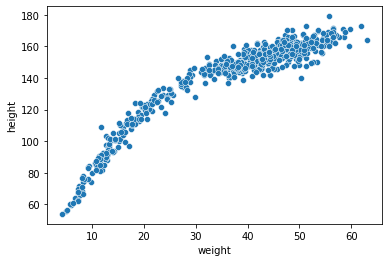

In [311]:
sns.scatterplot(x="weight", y="height", data=d);